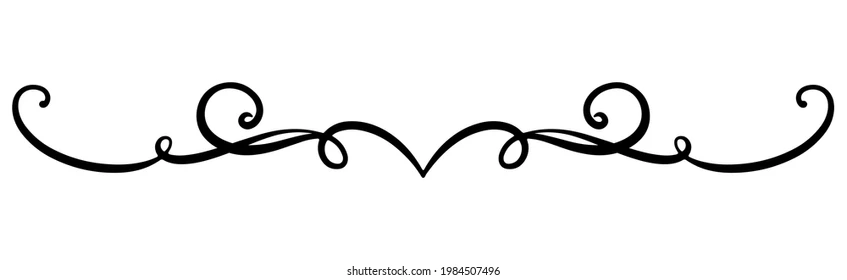

#**Natural language to SQL**

In [ ]:
##%%capture ## install the required packages
%pip install pytz
%pip install openai
%pip install langchain
%pip install langchain_community
%pip install llama-cpp-python
%pip install transformers huggingface_hub
%pip install langchain-experimental
#%pip install transformers -U
%pip install huggingface_hub
%pip install langchain-experimental
%pip install pandasql
%pip install pandas sqlalchemy

  Using cached llama_cpp_python-0.2.86.tar.gz (49.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for llama-cpp-python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llama-cpp-python
Failed to build llama-cpp-python
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (llama-cpp-python)


In [ ]:
#import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlite3
import pandasql as ps
import sqlalchemy

import requests
from typing import List
from operator import itemgetter
import json
import tqdm
import random
from IPython.display import display, Markdown, Latex

from huggingface_hub import hf_hub_download

import os
from langchain_community.llms import HuggingFaceEndpoint
from langchain import OpenAI, SQLDatabase
from langchain import PromptTemplate, LLMChain
from langchain.chains import create_sql_query_chain
from langchain_community.chat_models import ChatOpenAI
from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough


##Please upload below files to the google drive before you run the next code
1. customer_dim.csv
2. product_dim.csv
3. sales_transactions.csv
5. hf_token.rtf

In [ ]:
#Create 3 dataframes from the existing csv files saved in the drive
cust_data = pd.read_csv("/content/customer_dim.csv")
product_data = pd.read_csv("/content/product_dim.csv")
order_data = pd.read_csv("/content/sales_transactions.csv")


_______________________________________________________________________________

##Exploratory Data Analysis



________________________________________________________________________________

In [ ]:
#Investigate data
cust_data.head()

,cust_id,cust_address,cust_age,effective_start_date,effective_end_date,current_ind
0,185057,"335 Meadow St, Los Angeles, CA 90001",15,1900-01-01,9999-12-31,Y
1,225569,"753 Adams St, Portland, ME 04101",15,1900-01-01,9999-12-31,Y
2,134924,"295 Dogwood St, New York City, NY 10001",15,1900-01-01,9999-12-31,Y
3,218931,"40 Jefferson St, Atlanta, GA 30301",15,1900-01-01,9999-12-31,Y
4,140361,"169 Lake St, Boston, MA 02215",15,1900-01-01,9999-12-31,Y


In [ ]:
#check for null values
order_data.isnull().sum()

order_id            0
product_id          0
cust_id             0
product_quantity    0
order_date          0
dtype: int64

In [ ]:
#investigate the data
product_data.head()

,product_id,product_name,product_price,effective_start_date,effective_end_date,current_ind
0,582,iPhone,635.0,2019-10-01,2019-11-30,N
1,582,iPhone,689.0,2019-06-01,2019-09-30,N
2,582,iPhone,649.0,2019-04-01,2019-05-31,N
3,582,iPhone,700.0,1900-01-01,2019-03-31,N
4,216,LG Dryer,610.0,2019-06-01,2019-06-30,N


In [ ]:
#drop null values from the dataframe
order_data.dropna(inplace=True)


In [ ]:
#investigate the order data
order_data.tail()

,order_id,product_id,cust_id,product_quantity,order_date
185945,267890,692,206766,3,2019-10-06
185946,271869,692,203170,3,2019-10-06
185947,266115,692,144006,3,2019-10-06
185948,277783,692,194323,4,2019-10-06
185949,274286,692,208841,5,2019-10-06


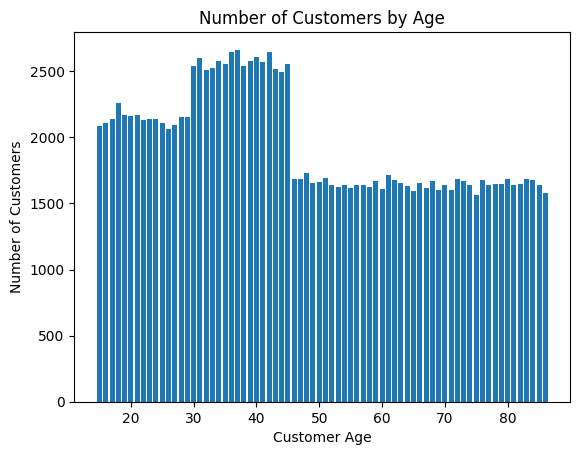

In [ ]:
# Group the data by customer ID and age
customer_counts = cust_data.groupby('cust_age')['cust_id'].nunique()

# Create a bar plot
plt.bar(customer_counts.index, customer_counts.values)
plt.xlabel('Customer Age')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Age')
plt.show()

In [ ]:
#investigate the product data
product_data.head()

,product_id,product_name,product_price,effective_start_date,effective_end_date,current_ind
0,582,iPhone,635.0,2019-10-01,2019-11-30,N
1,582,iPhone,689.0,2019-06-01,2019-09-30,N
2,582,iPhone,649.0,2019-04-01,2019-05-31,N
3,582,iPhone,700.0,1900-01-01,2019-03-31,N
4,216,LG Dryer,610.0,2019-06-01,2019-06-30,N


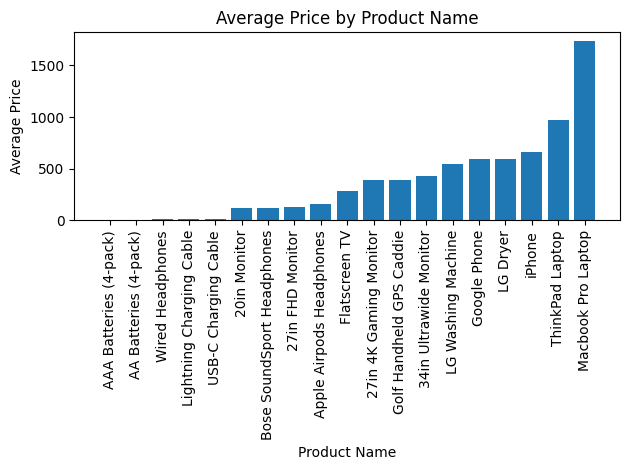

In [ ]:
# Group the data by product name and calculate the average price
product_prices = product_data.groupby('product_name')['product_price'].mean().sort_values()

# Create a bar plot
plt.bar(product_prices.index, product_prices.values)
plt.xlabel('Product Name')
plt.ylabel('Average Price')
plt.title('Average Price by Product Name')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# prompt: TOTAL NUMBER OF SALES TRANSACRTION ON THE 20TH JANUARY 2019

# Filter the order data for transactions on January 20th, 2019
transactions_on_jan_20 = order_data[order_data['order_date'] == '2019-01-20']

# Count the number of transactions
total_transactions = transactions_on_jan_20.shape[0]

print("Total number of sales transactions on January 20th, 2019:", total_transactions)


Total number of sales transactions on January 20th, 2019: 347


####Macbook pro followed by thinkpad are the highest priced products

In [ ]:
# Group the order data by product ID and sum the quantities
product_sales = order_data.groupby('product_id')['product_quantity'].sum().sort_values(ascending=False)

# Select the top 10 selling products
top_10_products = product_sales.head(10)

# Display the result in a table
top_10_products_df = pd.DataFrame({'Product ID': top_10_products.index, 'Total Sales': top_10_products.values})
display(top_10_products_df)


,Product ID,Total Sales
0,692,31017
1,406,27635
2,715,23975
3,981,23217
4,277,20557
5,953,15661
6,467,13457
7,443,7550
8,582,6849
9,877,6244


#Connect Datframe to database

In [ ]:
import sqlite3

# Create or connect to the database file (replace 'my_database.db' with your desired name)
conn = sqlite3.connect('my_database.db')

In [ ]:
#Create three tabes in the my_database
cust_data.to_sql('customers', conn, if_exists='replace',index=False)  # Append data to existing table
product_data.to_sql('products', conn, if_exists='replace', index=False)
order_data.to_sql('orders', conn, if_exists='replace', index=False)

conn.close()


#Testing a few SQL codes

In [ ]:
#Define a function to read the database using SQL
def read_sql_query(sql, db):
  conn = sqlite3.connect(db)
  cur = conn.cursor()
  cur.execute(sql)
  rows = cur.fetchall()
  for row in rows:
    print(row)
  conn.close()



In [ ]:
#check the total iphone records
read_sql_query("SELECT * FROM orders WHERE product_id = 582 AND order_date = '2019-01-24' LIMIT 60","my_database.db")

(147502, 582, 218385, 1, '2019-01-24')
(149914, 582, 161839, 1, '2019-01-24')
(145059, 582, 203984, 1, '2019-01-24')
(143998, 582, 100923, 1, '2019-01-24')
(150260, 582, 201340, 1, '2019-01-24')
(144877, 582, 183043, 1, '2019-01-24')
(146701, 582, 146678, 1, '2019-01-24')
(142058, 582, 136355, 1, '2019-01-24')
(141972, 582, 197187, 1, '2019-01-24')
(145964, 582, 133415, 1, '2019-01-24')
(148904, 582, 230302, 1, '2019-01-24')
(143040, 582, 131536, 1, '2019-01-24')


In [ ]:
# Question1: Get sql query to find the price of LG dryer


read_sql_query("SELECT DISTINCT product_price FROM products WHERE product_name = 'LG Dryer'", "my_database.db")



(610.0,)
(590.0,)
(600.0,)
(630.0,)
(550.0,)


In [ ]:
# Question2: What are the table names?


read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", "my_database.db")


('customers',)
('products',)
('orders',)


In [ ]:
# Question 3: select top 3 raws in the customer table
read_sql_query("SELECT * FROM customers LIMIT 3", "my_database.db")

(185057, '335 Meadow St, Los Angeles, CA 90001', 15, '1900-01-01', '9999-12-31', 'Y')
(225569, '753 Adams St, Portland, ME 04101', 15, '1900-01-01', '9999-12-31', 'Y')
(134924, '295 Dogwood St, New York City, NY 10001', 15, '1900-01-01', '9999-12-31', 'Y')


In [ ]:
# Question 4: select top selling products by quantity

read_sql_query("SELECT product_name, SUM(product_quantity) as total_quantity FROM orders JOIN products ON orders.product_id = products.product_id GROUP BY product_name ORDER BY total_quantity DESC LIMIT 5", "my_database.db")

('AAA Batteries (4-pack)', 248136)
('USB-C Charging Cable', 239750)
('AA Batteries (4-pack)', 221080)
('Lightning Charging Cable', 208953)
('Wired Headphones', 143899)


In [ ]:
# How many times Iphones were sold on the 20th January
read_sql_query("SELECT SUM(product_quantity) as total_quantity FROM orders WHERE product_id = 582 AND order_date = '2019-01-20'", "my_database.db")

(10,)


In [ ]:
#average age of a customer who buy Google phone
read_sql_query("SELECT AVG(customers.cust_age) FROM customers JOIN orders ON customers.cust_id = orders.cust_id JOIN products ON orders.product_id = products.product_id WHERE products.product_name = 'Google Phone'", "my_database.db")

(51.3847963800905,)


In [ ]:
# Total revenue on the 24th January
read_sql_query("SELECT SUM(products.product_price * orders.product_quantity) AS total_sales_revenue FROM products JOIN orders ON products.product_id = orders.product_id WHERE orders.order_date = '2019-01-24'", "my_database.db")

(332753.56999999244,)


In [ ]:
# Total revenue on the 24th January debug
read_sql_query("SELECT products.product_id, products.product_price, orders.order_id, orders.product_quantity FROM products JOIN orders ON products.product_id = orders.product_id LIMIT 20", "my_database.db")

(582, 635.0, 141234, 1)
(582, 635.0, 141336, 1)
(582, 635.0, 141394, 1)
(582, 635.0, 141437, 1)
(582, 635.0, 141457, 1)
(582, 635.0, 141458, 1)
(582, 635.0, 141460, 1)
(582, 635.0, 141472, 1)
(582, 635.0, 141473, 1)
(582, 635.0, 141476, 1)
(582, 635.0, 141504, 1)
(582, 635.0, 141517, 1)
(582, 635.0, 141520, 1)
(582, 635.0, 141550, 1)
(582, 635.0, 141582, 1)
(582, 635.0, 141632, 1)
(582, 635.0, 141663, 1)
(582, 635.0, 141670, 1)
(582, 635.0, 141702, 1)
(582, 635.0, 141703, 1)


In [ ]:
#how many customers ordered products on the 24th January 2019
read_sql_query("SELECT Count(*) FROM orders WHERE order_date = '2019-01-24' LIMIT 3", "my_database.db")

(348,)


In [ ]:
#How many customers are age of 15?
read_sql_query("SELECT Count(*) FROM customers WHERE cust_age = 15 LIMIT 3", "my_database.db")

(2086,)


In [ ]:
#How unique customers are in the database
read_sql_query("SELECT DISTINCT COUNT(cust_id) FROM customers LIMIT 3", "my_database.db")

(140787,)


In [ ]:
#Question 11, total sales on the 20th Jan 2019
read_sql_query("SELECT SUM(products.product_price * orders.product_quantity) as total_sales FROM orders JOIN products ON orders.product_id = products.product_id WHERE orders.order_date = '2019-01-20'", "my_database.db")

(412353.9899999932,)


In [ ]:
#Question 11, total sales on the 20th Jan 2019
read_sql_query("SELECT SUM(o.product_quantity) AS total_sales FROM products p JOIN orders o ON p.product_id = o.product_id WHERE o.order_date = '2019-01-20'", "my_database.db")

(2806,)


In [ ]:
read_sql_query("SELECT o.order_id, p.product_name, o.product_quantity, o.order_date FROM orders o JOIN products p ON o.product_id = p.product_id WHERE o.order_date = '2019-01-20' LIMIT 25 ", "my_database.db")

(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(145644, 'Wired Headphones', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(142272, 'Google Phone', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(147955, 'AAA Batteries (4-pack)', 1, '2019-01-20')
(148706, '

In [ ]:
read_sql_query("SELECT COUNT(*) AS total_orders FROM orders", "my_database.db")

(185950,)


In [ ]:
#Question 12 how many customer bought macbook on the first of january

read_sql_query("SELECT COUNT(DISTINCT orders.cust_id) FROM orders JOIN products ON orders.product_id = products.product_id WHERE products.product_name = 'Macbook Pro Laptop' AND order_date = '2019-10-01'", "my_database.db")

(22,)


####I did not use the hugging face environment as it was not compatible with lage size LLMs

________________________________________________________________________________

##Connect Openrouter.ai LLMs

The rest of the note book uses Open Router environment to connect the llms.  I used my personal account to connect to this environment.  Please do not use this key anywhere else.


In [ ]:
#Creat The environment and open API key
#kept it blank



In [ ]:
#Define the LLM (after several LLM testing I chose to use Open chat)
llm = ChatOpenRouter(
    model_name="openchat/openchat-7b",
    max_tokens=100, temperature = 0
)

# Connect to your SQLite database using SQLAlchemy
db_url = 'sqlite:///my_database.db'
engine = sqlalchemy.create_engine(db_url)

# Wrap the SQLAlchemy engine in a SQLDatabase object
db = SQLDatabase(engine)

# Pass the SQLDatabase object
db_agent = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [ ]:
#Define the list of questions
Question_1 = "What are the prices of LG Dryer?"
Question_2 = "what are the table names?"
Question_3 = "what are the first three items of the customer table?"
Question_4 = "what are the highest selling product names?"
Question_5 = "what are top highest average price products?"
Question_6 = "What is the iphones sales on the 20th of January 2019?"
Question_7 = "What is the average age of the customers who bought Google Phone"
Question_8 = "What is the total sales on the 2019-01-24"
Question_8_1 = "What is the all products revenue on the 2019-01-24"
Question_9 = "How many customers are age of 15"
Question_10 = "How many unique customer IDs are in the database"

#More chatty questions
Question_11 = "Hey all my analysts are away, I want to find out the sales for 20th january 2019, is it possible to find that for me?"
Question_11_1 = "Hey all my analysts are away, I want to find out the product sales values for 20th january 2019, is it possible to find that for me?"
Question_12 = "Can I find out know how many customers bought Macbook Pro Laptop on the 1st october 2019"
Question_13 = "Can I find out know how many customers bought 422 product_id on the 1st october 2019"

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#**Testing the LLM Input/ Output**

In [ ]:
#define my input
Input = {"question": Question_12}

In [ ]:
#Generate the SQL query

generate_query = create_sql_query_chain(llm, db)
query = generate_query.invoke(Input)
print(query)

SELECT COUNT(DISTINCT cust_id) FROM orders WHERE product_name = "Macbook Pro Laptop" AND order_date = "2019-10-01"


In [ ]:
#Execute the SQL query


execute_query = QuerySQLDataBaseTool(db=db)
execute_query.invoke(query)


'Error: (sqlite3.OperationalError) no such column: product_name\n[SQL: SELECT COUNT(DISTINCT cust_id) FROM orders WHERE product_name = "Macbook Pro Laptop" AND order_date = "2019-10-01"]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

In [ ]:
#Create a chain to invoke the query
chain = generate_query | execute_query
chain.invoke(Input)

'[(132,)]'

In [ ]:

chain.get_prompts()[0].pretty_print()


You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

In [ ]:
#define the prompt to answer user question
answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQl query, and SQL Result, answer the user question.


    Question: {question}

    SQL Result: {result}

    Answer:
    """
)

#Rephrase answer to natural language
rephrase_answer = answer_prompt | llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=generate_query).assign(
        result=itemgetter("query") | execute_query
    )
    | rephrase_answer
)

#print the final result
print("Your SQL Query is", query)
print("____________________________________")
chain.invoke(Input)
print("and the answer is", chain.invoke(Input))


Your SQL Query is SELECT COUNT(DISTINCT cust_id) FROM orders WHERE product_name = "Macbook Pro Laptop" AND order_date = "2019-10-01"
____________________________________
and the answer is  Yes, you can find out how many customers bought Macbook Pro Laptop on the 1st of October 2019. The SQL query provided returns the number of customers, which is 132.


##Summary:

9 out of 12 times, the model extracted the correct data from the database using SQL query.  The results related to sales were more accuarte.  However the chain was able to solve complex issues of joining multiple tables to find the final answer

In [ ]:

#Option 2
#The code to get the answer using agent that was not used in the final model

#define the function to generate the answer
def get_answer_from_sql_db(question, db_agent):
  response = db_agent.run(question)
  return response


# define the agent using SQLDatabase object
db_agent = SQLDatabaseChain.from_llm(llm, db, verbose=True)

#print the result using database agent, this was not the optimum solution
print(get_answer_from_sql_db(Question_11, db_agent))





> Entering new SQLDatabaseChain chain...
Hey all my analysts are away, I want to find out the sales for 20th january 2019, is it possible to find that for me?
SQLQuery:SELECT SUM(product_quantity) as total_products_sold
FROM orders
WHERE order_date = '2019-01-20'
SQLResult: [(385,)]
Answer:Yes, the sales for 20th January 2019 were 385 products.
> Finished chain.
Yes, the sales for 20th January 2019 were 385 products.


##Conclusion

Open chat LLM Chat demonstrated superior performance in generating accurate responses to user queries when integrated with Langchain. The model correctly answered nine out of twelve test questions. To enhance commercial viability, code refinement and expanded model training incorporating diverse business terminology are recommended. While the LLM agent (option 2) was explored, inconsistent results precluded its use in this project.



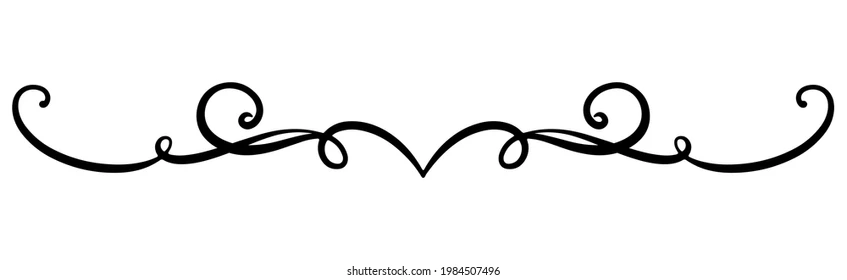